In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, copy, os, shutil
from tqdm.notebook import tqdm
import seaborn as sns
from importlib import reload

import GridWorldHelpers as gwh

Load and visualize baseline grid world, world with normal pond, world with overflow pond in terms of their  (mean **rewards**)

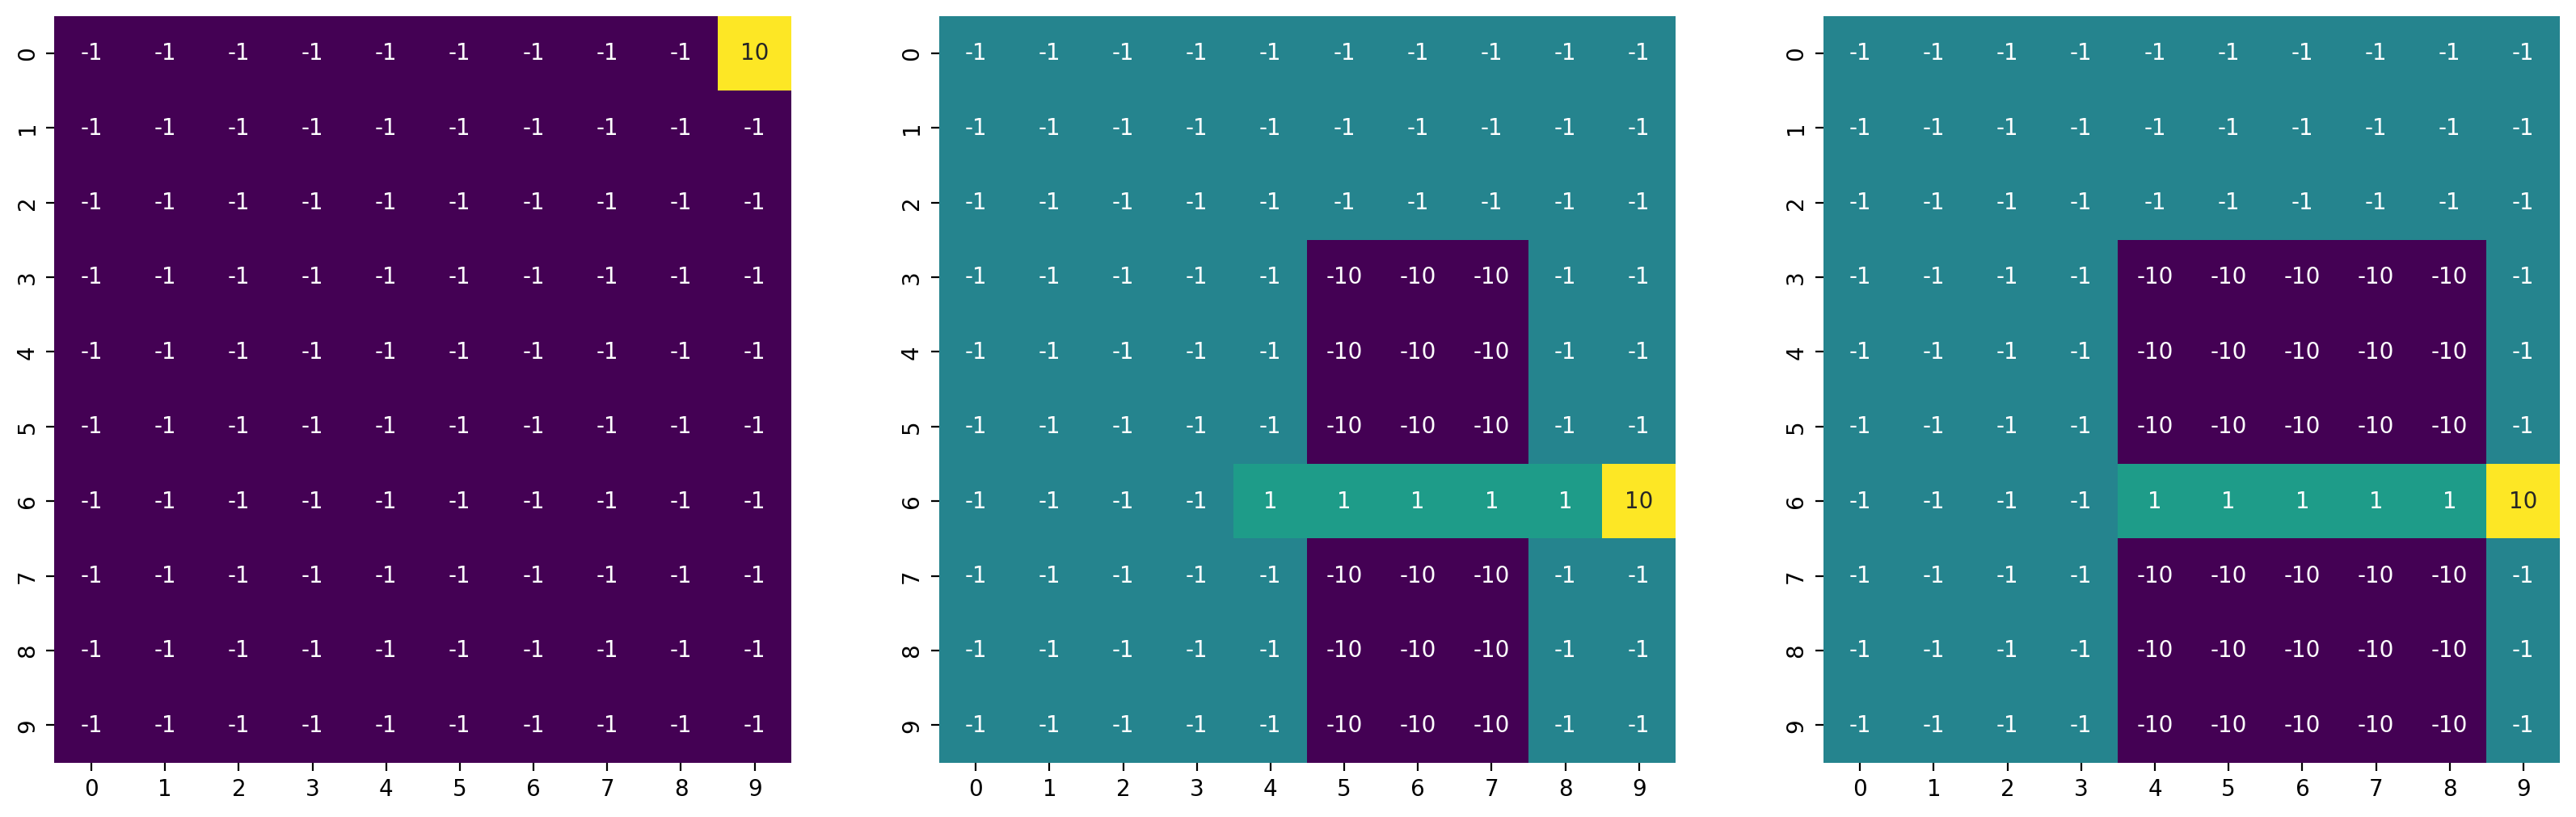

In [23]:
gw0, gw1, gw2 = gwh.build_grids()

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(20, 6))
gwh.visualize_reward_grid(gw0, ax[0])
gwh.visualize_reward_grid(gw1, ax[1])
gwh.visualize_reward_grid(gw2, ax[2])

Obtain and visualize the colors grids for each of the grid worlds

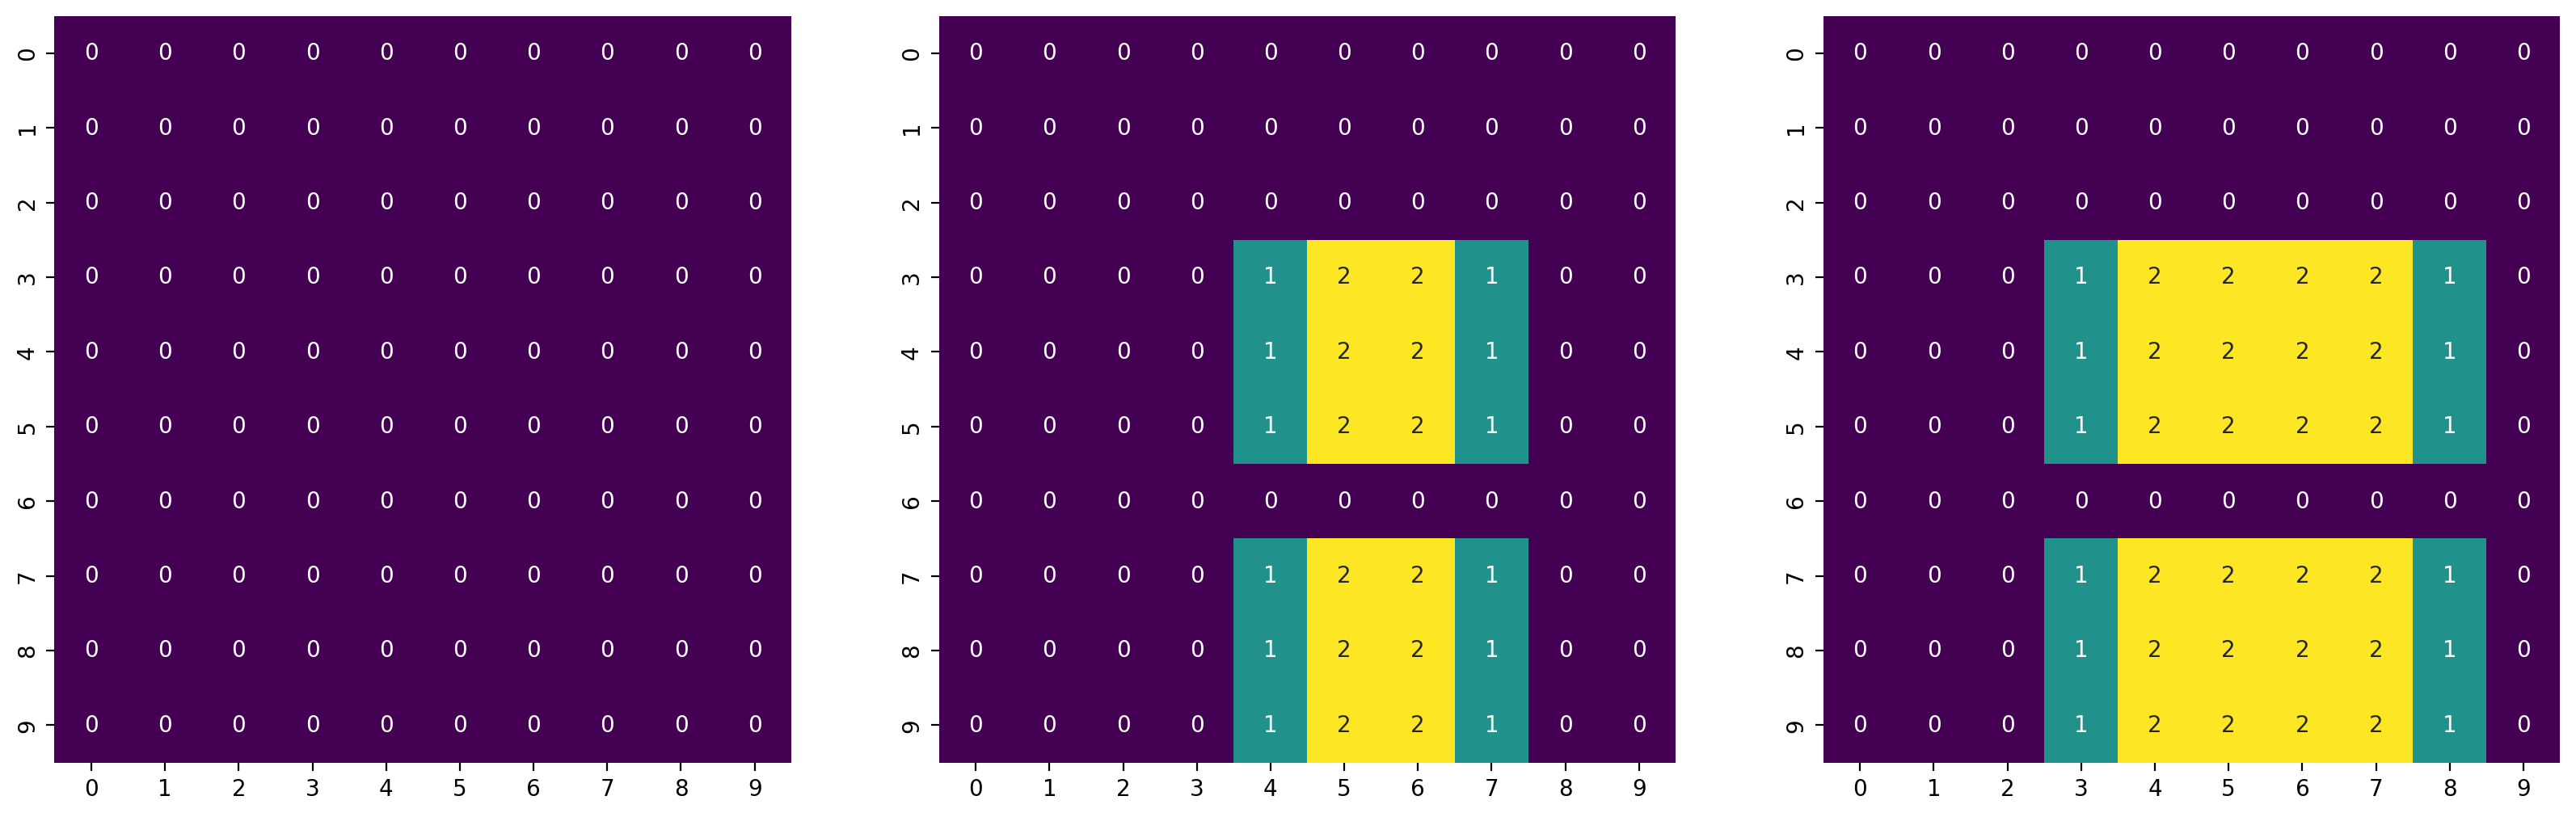

In [39]:
# make the color-grid for GridWorld1
gw0_colors = gwh.make_gw_colors(gw0) 
gw1_colors = gwh.make_gw_colors(gw1)
gw2_colors = gwh.make_gw_colors(gw2)

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(20, 6))
gwh.visualize_reward_grid(gw0_colors, ax[0])
gwh.visualize_reward_grid(gw1_colors, ax[1])
gwh.visualize_reward_grid(gw2_colors, ax[2])

### Parameters and initialization

* **TODO** function which initializes agent location
* for now just setting all to 0.5

In [101]:
p_switch = 0.5 #water stochasticity
p_wind_i = 0.5 #probability of wind at each step
p_wind_j = 0.5
ce = 0 #start at current environment 1

## Procedure

At each time $t$

1. Run ``gwh.get_environment()`` with parameter ``p_overflow`` to determine if pond has overflowed or not (**water stochasticity**).

   * Note: for baseline environment, there is no pond and p is set to 0 
   * I made it so that overflow is markovian with $p(new|current)=p$ and $p(current|current)=p$. That ways there's more of a MDP type thing to learn.

   
2. Using ``gwh.sync_color``, obtain color for current location and update True State

3. **TODO** Using some missing data function, determine agent's observed state

4. **Agent**: given observed state ``Ostate``, previous state and previous action, any relevant objects learned from the history, run ``Learner()`` to output an action ``a``

5. **System** given true state ``Tstate`` and action ``a``,

* generate next true $(x,y)$ (stochastic due to **wind**), **but** not yet updating color because environment might change (e.g., based on current green, you decide to go right but by the time you get there, your next location actually is flooded)
 


In [108]:
reload(gwh)

# set-up the possible environments
environments = {
                0: [gw1,gw1_colors], #baseline
                1: [gw2, gw2_colors] #flooding
               }

# pick current environment 
ce = gwh.get_environment(ce, p_switch)

# given pick, get the reward grid and the color grid to use for this step
gw = environments[ce][0]
gw_colors = environments[ce][1]

# we know current (x,y) from a previous step  - for now, pretend it is this
# get color from current environment
Tstate = np.array([1,1,np.nan]) #(x,y green)
Tstate = gwh.sync_color(Tstate, gw_colors)

#TODO: missing data mechanism applied to determine observed state
Ostate = None

#TODO: learning algorithm to pick an action, for now pretend it's up
a = (0,1)

# Implement move but we don't know color this move will result in yet
# Also, possibly there is some wind blowing us off course
Tstate_new = gwh.true_move(Tstate, a, gw, gw_colors, p_wind_i, p_wind_j)

print(Tstate, Tstate_new)

[1. 1. 0.] [ 0.  0. nan]


# TODO - polish and move over missing data functions 


In [138]:
# first missing data function: can have DIFFERENT THETAS FOR EACH COMPONENT!
# case1: thetas all the same, case2: thetas different.
def MCAR(state, thetas):
    
    # make a copy to stay safe: "partially-observed state"
    po_state = state.copy().astype(float)
    
    # generate three bernoullis: theta is PROBABILITY OF BEING MISSING!
    mask = np.random.binomial(1, thetas).astype(bool)
    po_state[mask] = np.nan
    
    # return our missing-operated state
    return po_state

In [167]:
# a list of (theta_i, theta_j, theta_c) for each color c
# FILL IN THESE VALUES LATER.
thetas_MAR_dict = {0: np.array([]),
                   1: np.array([]),
                   2: np.array([])}


# learning x,y|c is MAR
# learning c|x,y is not MAR because if colors missing at different rates, 
# could skew our assessment of how likely color actually is for that x,y
# only really becomes more relevant when stochastic water so color is random
# second missing data function: different thetas for each color that we're currently in.
def Mcolor(state): # "partially-MAR"
    
    # query what our true color is + get the corresponding thetas_c vector
    c = int(state[2]); thetas_c = thetas_MAR_dict[c]
    
    # use MCAR
    return MCAR(state, thetas_c)

In [ ]:
# put "fog" in a region governed by {i_range x j_range}. If you are in that region, 
def Mfog(state, i_range, j_range, thetas_inregion, thetas_outregion):
    
    # default to not being in the region
    inregion = False
    
    # check if we're in the fog region or not
    if np.clip(a=state[0], a_min=i_range[0], a_max=i_range[1]) == state[0]:
        if np.clip(a=state[1], a_min=j_range[0], a_max=j_range[1]) == state[1]:
            inregion = True
            
    # figure out what thetas to use + apply the MCAR
    thetas = thetas_inregion if inregion else thetas_outregion
    po_state = MCAR(state, thetas)

# TODO - move this into a test notebook

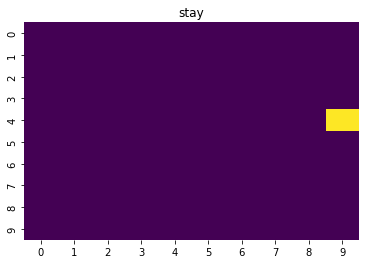

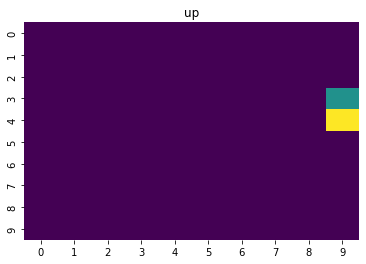

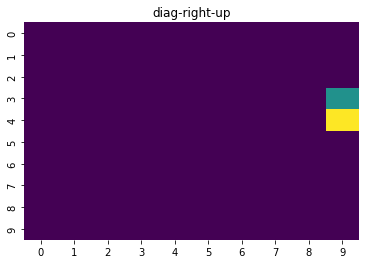

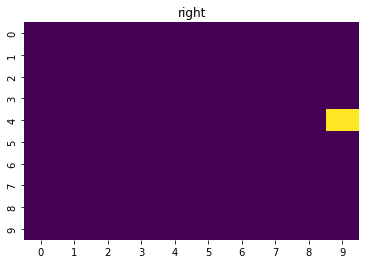

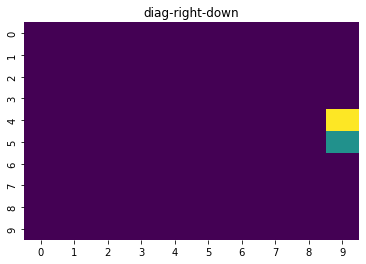

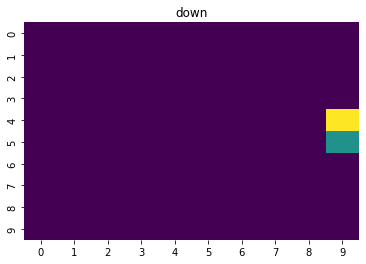

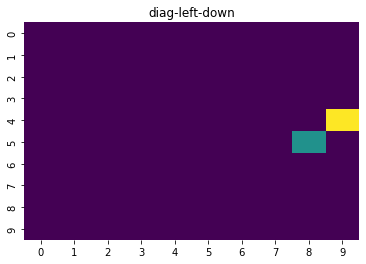

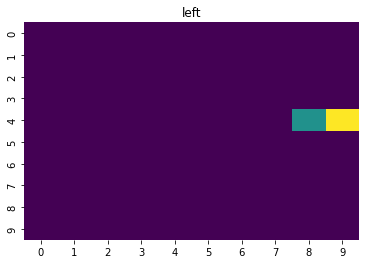

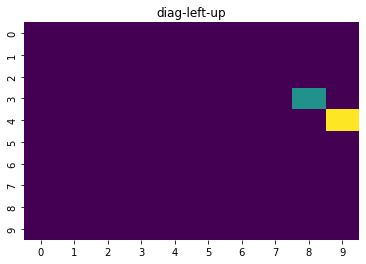

In [90]:
# try all possible actions
for a in list(action_descs.keys()):
    
    # try a test-case
    gw = np.zeros((d,d))

    # initialize our state randomly
    state = np.array([4, 9, 1])
    gw[state[0], state[1]] = +100
    
    # get our new state
    new_state = true_move(state, a, gw, gw1_colors)
    gw[new_state[0], new_state[1]] = 50
    
    sns.heatmap(gw, cbar=False, cmap="viridis")
    plt.title(action_descs[a])
    plt.show()